# NBA Game Prediction: Logistic Regression
Written by Nicholas Cannon 22241579

In [211]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, FunctionTransformer
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve
)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'teams')
STATE = 42
team_ids = os.listdir(DATA_DIR)
NON_FEATURE_COLS = ['GAME_ID', 'DATE', 'SEASON', 'TEAM', 'OPPONENT']

# Modelling Teams Individually

In [212]:
def preprocess_team(team_id, drop_cols='attempts', season_avg=False, window=5, test_size=0.2, split_data=True):
    """
    Preprocess the given teams data set with configurable options.
    """
    df = pd.read_csv(os.path.join(DATA_DIR, team_id))

    # shift label up 1 game
    df['WON'] = df['WON'].shift(periods=-1)
    df.dropna(inplace=True)

    # get a copy of the columns not run through averaging
    non_avgs = df[[*NON_FEATURE_COLS, 'HOME']].copy()

    # separate features and labels (and drop non feature cols)
    X = df.drop([*NON_FEATURE_COLS, 'WON', 'HOME'], axis=1)
    y = df['WON']

    # drop derived cols
    if drop_cols == 'percentages':
        X = X.drop(['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'RBC'], axis=1)
    elif drop_cols == 'attempts':
        X = X.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'ORBC', 'DRBC',], axis=1)
    elif drop_cols != '':
        raise ValueError("drop_cols must equal 'percentages', 'attempts' or ''")

    # Run averaging and add the non_avg cols after
    if season_avg:
        X = X.expanding().mean()
        X = pd.concat([non_avgs, X], axis=1)
    else:
        X = X.rolling(window).mean()
        X = pd.concat([non_avgs, X], axis=1)

        X.dropna(inplace=True) # drop first few games
        y = y[window-1:]
    
    if split_data:
        return train_test_split(X, y, test_size=test_size, random_state=STATE)
    else:
        return X, y


def train_team(team_id, clf, **preprocess_args):
    """
    Train individual team by team_id.
    """
    X_train, X_test, y_train, y_test = preprocess_team(team_id, **preprocess_args)
    clf.fit(X_train, y_train)
    return clf.best_estimator_, X_train, X_test, y_train, y_test, clf.score(X_test, y_test)


def train_all(team_ids, **preprocess_args):
    """
    Train all teams (passed by team_ids) and return dict with models and 
    split data.
    """
    models = {}
    scores = []

    pipe = Pipeline([
        ('drop_cols', FunctionTransformer(lambda X: X.drop(NON_FEATURE_COLS, axis=1))),
        ('scaler', StandardScaler()),
        ('k_bins', KBinsDiscretizer(strategy='kmeans')),
        ('sgd', SGDClassifier(loss='log', random_state=STATE))
    ])
    params = {
        'k_bins__n_bins': [8, 10, 12],
        'sgd__class_weight': [None, 'balanced'],
        'sgd__penalty': ['l1', 'l2', 'none'],
    }

    clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)

    for team_id in tqdm(team_ids):
        estimator, *data, score = train_team(team_id, clf, **preprocess_args)
        models[team_id] = {'clf': estimator, 'data': data}
        scores.append(score)

    # print stats
    print('Mean score = {}'.format(np.mean(scores)))
    print('Max score = {}'.format(np.max(scores)))
    print('Min score = {}'.format(np.min(scores)))

    return models


def plot_total_cf(models):
    """
    Plot confusion matrix across multiple models.
    """
    cf = np.zeros((2, 2))
    total = 0
    for team, model in models.items():
        y_pred = model['clf'].predict(model['data'][1])
        total += len(y_pred)
        cf = np.add(cf, confusion_matrix(model['data'][-1], y_pred))

    mat = ConfusionMatrixDisplay(cf)
    mat.plot(cmap=plt.cm.Blues, values_format='.0f')

## Experiment 1: 5 Game moving Average, Dropping attempts

100%|██████████| 30/30 [01:26<00:00,  2.89s/it]
Mean score = 0.542517006802721
Max score = 0.6326530612244898
Min score = 0.4387755102040816


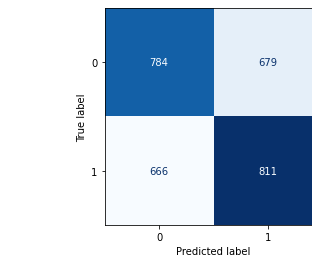

In [213]:
models = train_all(team_ids, drop_cols='attempts', season_avg=False, window=5)
plot_total_cf(models)

## Experiment 2: Season Average, Dropping attempts

100%|██████████| 30/30 [01:27<00:00,  2.92s/it]
Mean score = 0.5393939393939394
Max score = 0.6767676767676768
Min score = 0.43434343434343436


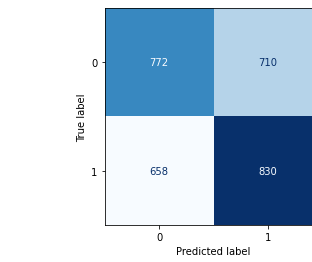

In [214]:
models = train_all(team_ids, drop_cols='attempts', season_avg=True)
plot_total_cf(models)

## Experiment 3: Game Moving Average, Dropping Percentages

100%|██████████| 30/30 [01:27<00:00,  2.90s/it]
Mean score = 0.5370748299319728
Max score = 0.6428571428571429
Min score = 0.40816326530612246


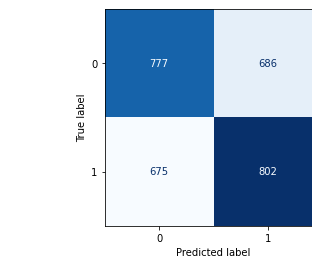

In [215]:
models = train_all(team_ids, drop_cols='percentages', season_avg=False, window=5)
plot_total_cf(models)

## Experiment 4: Season Average, Dropping percentages

100%|██████████| 30/30 [01:43<00:00,  3.44s/it]
Mean score = 0.5437710437710436
Max score = 0.6363636363636364
Min score = 0.45454545454545453


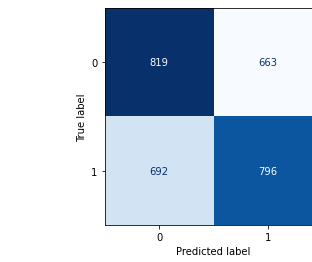

In [216]:
models = train_all(team_ids, drop_cols='percentages', season_avg=True)
plot_total_cf(models)

In [217]:
# np.around(
#     models[team_ids[0]]['clf'].predict_proba(models[team_ids[0]]['data'][1]),
#     decimals=3
# )

# Single Model for all teams

In [218]:
def train_full(**preprocess_args):
    # Build data set from team sets
    X_full, y_full = pd.DataFrame(), pd.DataFrame()
    for team_id in team_ids:
        X_team, y_team = preprocess_team(team_id, split_data=False, **preprocess_args)

        X_full = pd.concat([X_full, X_team])
        y_full = pd.concat([y_full, y_team])

    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=STATE)
    
    pipe = Pipeline([
        ('drop_cols', FunctionTransformer(lambda X: X.drop(NON_FEATURE_COLS, axis=1))),
        ('scaler', StandardScaler()),
        ('k_bins', KBinsDiscretizer()),
        ('sgd', SGDClassifier(loss='log', random_state=STATE))
    ])
    params = {
        'k_bins__n_bins': [5, 8],
        'k_bins__strategy': ['kmeans', 'uniform', 'quantile'],
        'sgd__class_weight': [None, 'balanced'],
        'sgd__penalty': ['l1', 'l2'],
        
    }

    clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
    clf.fit(X_train, y_train)

    print(clf.best_params_)
    print(clf.score(X_test, y_test))

    return clf.best_estimator_, X_train, X_test, y_train, y_test

## Experiment 1: 5 Game Moving Average

In [219]:
clf_1, *data_1 = train_full()

{'k_bins__n_bins': 5, 'k_bins__strategy': 'uniform', 'sgd__class_weight': None, 'sgd__penalty': 'l1'}
0.5571526351813826


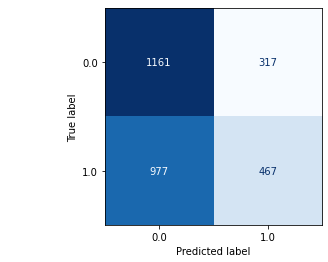

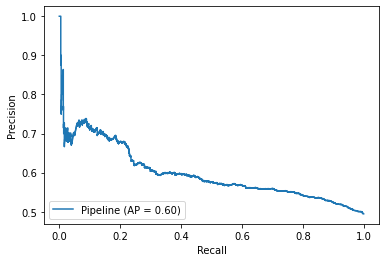

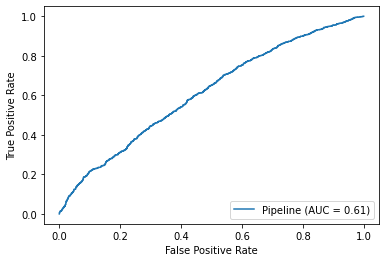

In [220]:
plot_confusion_matrix(clf_1, data_1[1], data_1[3], cmap=plt.cm.Blues)
plot_precision_recall_curve(clf_1, data_1[1], data_1[3])
plot_roc_curve(clf_1, data_1[1], data_1[3])

## Experiment 2: Season Average

In [221]:
clf_2, *data_2 = train_full(season_avg=True)

{'k_bins__n_bins': 5, 'k_bins__strategy': 'quantile', 'sgd__class_weight': 'balanced', 'sgd__penalty': 'l1'}
0.5801086218601493


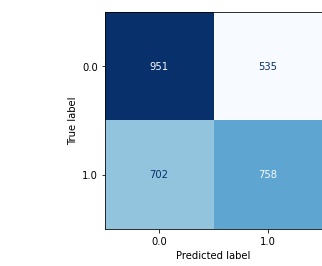

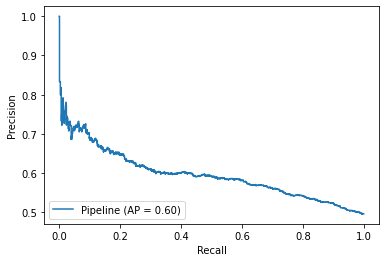

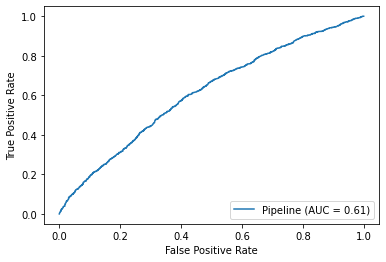

In [222]:
plot_confusion_matrix(clf_2, data_2[1], data_2[3], cmap=plt.cm.Blues)
plot_precision_recall_curve(clf_2, data_2[1], data_2[3])
plot_roc_curve(clf_2, data_2[1], data_2[3])